In [9]:
# Zelle 1: Setup & Config
from google.cloud import bigquery
from google.api_core.exceptions import NotFound

import pandas as pd
import uuid
import datetime
import matplotlib.pyplot as plt

# sorgt dafür, dass Plots im Notebook angezeigt werden
%matplotlib inline


In [2]:
# Zelle 1 & 2: Setup mit automatischer Regionen-Korrektur
from google.cloud import bigquery
from google.api_core.exceptions import NotFound
import logging
import uuid
import datetime

# Logging Setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# --- CONFIG ---
PROJECT_ID = "taxi-bi-project" # Deine ID aus dem Log
SOURCE_DATASET = "staging"     # <--- Laut deinem Fehlerlog heißt es "staging"!
TARGET_DATASET = "canonical"   

# Tabellen
TARGET_TABLE = "canonical_unified_taxi"
ERROR_TABLE = "error_records"
LOG_TABLE = "etl_process_log"

client = bigquery.Client(project=PROJECT_ID)

print("--- DIAGNOSE & REPARATUR ---")
try:
    src_ds_ref = client.get_dataset(f"{PROJECT_ID}.{SOURCE_DATASET}")
    CORRECT_LOCATION = src_ds_ref.location
    print(f"✅ QUELLE GEFUNDEN: Dataset '{SOURCE_DATASET}' liegt in Region: '{CORRECT_LOCATION}'")
except Exception as e:
    print(f"❌ KRITISCHER FEHLER: Konnte Quell-Dataset '{SOURCE_DATASET}' nicht finden!")
    print("Bitte prüfe: Heißt dein Dataset in BigQuery wirklich 'staging' oder 'taxi_dwh'?")
    raise e

# 2. Prüfen, ob das Ziel-Dataset 'canonical' falsch liegt
target_dataset_id = f"{PROJECT_ID}.{TARGET_DATASET}"
try:
    tgt_ds = client.get_dataset(target_dataset_id)
    if tgt_ds.location != CORRECT_LOCATION:
        print(f"⚠️ KONFLIKT: Ziel '{TARGET_DATASET}' ist in '{tgt_ds.location}', muss aber nach '{CORRECT_LOCATION}'.")
        print("   Lösche falsches Dataset...")
        client.delete_dataset(target_dataset_id, delete_contents=True, not_found_ok=True)
        print("   Gelöscht. Wird neu erstellt.")
        tgt_ds = None
except NotFound:
    tgt_ds = None

# 3. Ziel-Dataset korrekt neu erstellen
if not tgt_ds:
    new_ds = bigquery.Dataset(target_dataset_id)
    new_ds.location = CORRECT_LOCATION # <--- Hier zwingen wir die richtige Region!
    client.create_dataset(new_ds)
    print(f"ZIEL ERSTELLT: Dataset '{TARGET_DATASET}' erfolgreich in Region '{CORRECT_LOCATION}' angelegt.")
else:
    print(f"OK: Ziel-Dataset liegt bereits korrekt in '{CORRECT_LOCATION}'.")

# Globale Variablen aktualisieren
table_ref = f"{PROJECT_ID}.{TARGET_DATASET}.{TARGET_TABLE}"
error_table_ref = f"{PROJECT_ID}.{TARGET_DATASET}.{ERROR_TABLE}"
log_table_ref = f"{PROJECT_ID}.{TARGET_DATASET}.{LOG_TABLE}"

print("\nReady. Bitte jetzt Zelle 3 ausführen.")

--- DIAGNOSE & REPARATUR ---
✅ QUELLE GEFUNDEN: Dataset 'staging' liegt in Region: 'EU'
OK: Ziel-Dataset liegt bereits korrekt in 'EU'.

Ready. Bitte jetzt Zelle 3 ausführen.


In [14]:
def check_missing_locations_by_year():
    print("--- 🔍 DIAGNOSE: Fehlen Location IDs bei alten Yellow Trips? ---")
    
    # Wir gruppieren nach Jahr und zählen, wie viele IDs fehlen
    query = f"""
    SELECT 
        EXTRACT(YEAR FROM pickup_datetime) as year,
        COUNT(*) as total_trips,
        COUNTIF(pickup_location_id IS NULL OR pickup_location_id = 0) as missing_pu_ids,
        COUNTIF(dropoff_location_id IS NULL OR dropoff_location_id = 0) as missing_do_ids,
        
        -- Prozentualer Anteil der Fehler
        ROUND(COUNTIF(pickup_location_id IS NULL OR pickup_location_id = 0) / COUNT(*) * 100, 2) as pct_missing
        
    FROM `{table_ref}`  -- Das ist deine 'canonical_unified_taxi'
    WHERE source_system = 'YELLOW'
    GROUP BY 1
    ORDER BY 1
    """
    
    try:
        df = client.query(query).to_dataframe()
        print(df.to_string(index=False))
        
        # Sofortige Analyse
        if df['pct_missing'].max() > 10:
            print("\n⚠️ ALARM: Wir haben signifikante Lücken bei den Location IDs!")
            print("   -> Wahrscheinlich müssen wir Longitude/Latitude mappen.")
        else:
            print("\n✅ Entwarnung: Die Staging-Tabelle scheint das schon bereinigt zu haben.")
            
    except Exception as e:
        print(f"❌ Fehler bei der Diagnose: {e}")

check_missing_locations_by_year()

--- 🔍 DIAGNOSE: Fehlen Location IDs bei alten Yellow Trips? ---
 year  total_trips  missing_pu_ids  missing_do_ids  pct_missing
 2010     14688619               0               0          0.0
 2011     14743286               0               0          0.0
 2012     14975598               0               0          0.0
 2013     14264747               0               0          0.0
 2014     13695497               0               0          0.0
 2015     12298345               0               0          0.0
 2016     11110224               0               0          0.0
 2017      9637812               0               0          0.0
 2018      8625756               0               0          0.0
 2019      6811024               0               0          0.0
 2020       527358               0               0          0.0
 2021      2744022               0               0          0.0
 2022      3452058               0               0          0.0
 2023     37152495               0      

/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [ ]:
def inspect_staging_columns():
    print("--- 🕵️‍♂️ STAGING INSPECTION (Yellow Taxi) ---")
    
    # Wir schauen uns eine Zeile aus der Staging Tabelle an
    # Stelle sicher, dass der Tabellenname stimmt (yellow_staging_unified)
    table_id = f"{PROJECT_ID}.{SOURCE_DATASET}.yellow_staging_unified"
    
    try:
        # Wir laden nur die Spaltennamen
        df = client.query(f"SELECT * FROM `{table_id}` LIMIT 1").to_dataframe()
        
        print(f"Gefundene Spalten in '{table_id}':")
        cols = sorted(df.columns)
        for c in cols:
            print(f" - {c}")
            
        # Spezifischer Check auf Koordinaten
        print("Check:")
        coord_cols = [c for c in cols if 'lat' in c.lower() or 'lon' in c.lower()]
        if coord_cols:
            print(f"Koordinaten gefunden: {coord_cols}")
        else:
            print("Keine direkten Koordinaten-Spalten (Lat/Lon) gefunden.")

    except Exception as e:
        print(f"Fehler beim Lesen von Staging: {e}")

inspect_staging_columns()

--- 🕵️‍♂️ STAGING INSPECTION (Yellow Taxi) ---
Gefundene Spalten in 'taxi-bi-project.staging.yellow_staging_unified':
 - Airport_fee
 - DOLocationID
 - PULocationID
 - RatecodeID
 - VendorID
 - congestion_surcharge
 - dropoff_latitude
 - dropoff_longitude
 - duplicate_flag
 - extra
 - fare_amount
 - improvement_surcharge
 - missing_flag
 - mta_tax
 - passenger_count
 - payment_type
 - pickup_latitude
 - pickup_longitude
 - store_and_fwd_flag
 - tip_amount
 - tolls_amount
 - total_amount
 - tpep_dropoff_datetime
 - tpep_pickup_datetime
 - trip_distance

🔍 Koordinaten-Check:
✅ Koordinaten gefunden: ['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude', 'pickup_longitude']


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [11]:
# Zelle 2: Schema Definition (Fix: MONTH Partitioning)
def create_all_tables():
    base_schema = [
        bigquery.SchemaField("trip_id", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("source_system", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("load_date", "TIMESTAMP", mode="REQUIRED"),
        bigquery.SchemaField("vendor_id", "STRING"), 
        bigquery.SchemaField("Affiliated_base_number", "STRING"),
        bigquery.SchemaField("dispatching_base_nummer", "STRING"),
        bigquery.SchemaField("pickup_datetime", "TIMESTAMP", mode="REQUIRED"),
        bigquery.SchemaField("dropoff_datetime", "TIMESTAMP"),
        bigquery.SchemaField("pickup_location_id", "INT64"), 
        bigquery.SchemaField("dropoff_location_id", "INT64"), 
        bigquery.SchemaField("passenger_count", "INT64"),
        bigquery.SchemaField("trip_distance", "FLOAT64"),
        bigquery.SchemaField("store_and_fwd_flag", "STRING"),
        bigquery.SchemaField("RatecodeID", "INT64"),
        bigquery.SchemaField("Trip_type", "INT64"),
        bigquery.SchemaField("SR_Flag", "BOOLEAN"), 
        bigquery.SchemaField("fare_amount", "FLOAT64"),
        bigquery.SchemaField("tip_amount", "FLOAT64"),
        bigquery.SchemaField("total_amount", "FLOAT64"),
        bigquery.SchemaField("payment_type", "INT64"),
        bigquery.SchemaField("extra", "FLOAT64"),
        bigquery.SchemaField("mta_tax", "FLOAT64"),
        bigquery.SchemaField("tolls_amount", "FLOAT64"),
        bigquery.SchemaField("improvement_surcharge", "FLOAT64"),
        bigquery.SchemaField("congestion_surcharge", "FLOAT64"),
        bigquery.SchemaField("Airport_fee", "FLOAT64"), 
        bigquery.SchemaField("ehail_fee", "FLOAT64"),   
        bigquery.SchemaField("dq_issue_flag", "BOOLEAN") 
    ]

    error_schema = base_schema + [bigquery.SchemaField("rejection_reason", "STRING")]

    # Hier setzen wir explizit MONTH statt DAY
    tables_to_create = [
        (table_ref, base_schema, "pickup_datetime", bigquery.TimePartitioningType.MONTH),
        (error_table_ref, error_schema, "load_date", bigquery.TimePartitioningType.DAY) # Error bleibt DAY, da load_date nur HEUTE ist
    ]

    for t_ref, t_schema, p_field, p_type in tables_to_create:
        try:
            client.delete_table(t_ref, not_found_ok=True)
            t = bigquery.Table(t_ref, schema=t_schema)
            
            t.time_partitioning = bigquery.TimePartitioning(
                field=p_field,
                type_=p_type
            )
            
            t.clustering_fields = ["source_system", "vendor_id"]
            client.create_table(t)
            print(f"Tabelle neu erstellt: {t_ref.split('.')[-1]} (Partition: {p_type})")
        except Exception as e:
            print(f"Fehler bei {t_ref}: {e}")

create_all_tables()

Tabelle neu erstellt: canonical_unified_taxi (Partition: MONTH)
Tabelle neu erstellt: error_records (Partition: DAY)


In [12]:
def run_etl_split_logic():
    print(f"🚀 Starte finale ETL Pipeline mit Dubletten-Erkennung...")
    
    query = f"""
    BEGIN
        -- 1. TRANSFORMATION IN TEMP-SPEICHER
        CREATE OR REPLACE TEMP TABLE temp_trips_processed AS
        -- Definition der NYC Grenze als Auffangnetz
        WITH nyc_boundary AS (
            SELECT ST_UNION_AGG(zone_geom) as city_limit 
            FROM `{PROJECT_ID}.{SOURCE_DATASET}.taxi_zones_geo`
        ),
        combined_raw AS (
            -- (A) YELLOW
            SELECT
                'YELLOW' as src,
                -- Bereinigte VendorID
                CASE
                    -- 1. Creative Mobile (CMT) -> 1
                    WHEN UPPER(CAST(VendorID AS STRING)) IN ('CMT', '1') THEN '1'
                    
                    -- 2. VeriFone (VTS/Curb) -> 2
                    WHEN UPPER(CAST(VendorID AS STRING)) IN ('VTS', '2', 'VERIFONE', 'CURB') THEN '2'
                    
                    -- 3. Myle -> 6
                    WHEN CAST(VendorID AS STRING) = '6' THEN '6'
                    
                    -- 4. Helix -> 7
                    WHEN CAST(VendorID AS STRING) = '7' THEN '7'
                    
                    -- 5. Digital Dispatch (DDS) & Unknown / Rest -> 99
                    WHEN UPPER(CAST(VendorID AS STRING)) = 'DDS' THEN '99'
                    ELSE '99'
                END as vid,
                -- Zeitstempel
                COALESCE(SAFE_CAST(tpep_pickup_datetime AS TIMESTAMP), SAFE.PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S', CAST(tpep_pickup_datetime AS STRING))) as t_pick,
                COALESCE(SAFE_CAST(tpep_dropoff_datetime AS TIMESTAMP), SAFE.PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%S', CAST(tpep_dropoff_datetime AS STRING))) as t_drop,
                -- Location Pickup mit NYC-Boundary Logik
                CASE 
                    WHEN CAST(PULocationID AS INT64) BETWEEN 1 AND 263 THEN CAST(PULocationID AS INT64)
                    WHEN pickup_longitude != 0 AND pickup_latitude != 0 THEN 
                        COALESCE(
                            (SELECT ANY_VALUE(location_id) FROM `{PROJECT_ID}.{SOURCE_DATASET}.taxi_zones_geo` 
                             WHERE ST_WITHIN(SAFE.ST_GEOGPOINT(pickup_longitude, pickup_latitude), zone_geom)),
                            IF(ST_WITHIN(SAFE.ST_GEOGPOINT(pickup_longitude, pickup_latitude), (SELECT city_limit FROM nyc_boundary)), 264, 265)
                        )
                    ELSE 264 
                END as loc_pu,
                -- Location Dropoff mit NYC-Boundary Logik
                CASE 
                    WHEN CAST(DOLocationID AS INT64) BETWEEN 1 AND 263 THEN CAST(DOLocationID AS INT64)
                    WHEN dropoff_longitude != 0 AND dropoff_latitude != 0 THEN 
                        COALESCE(
                            (SELECT ANY_VALUE(location_id) FROM `{PROJECT_ID}.{SOURCE_DATASET}.taxi_zones_geo` 
                             WHERE ST_WITHIN(SAFE.ST_GEOGPOINT(dropoff_longitude, dropoff_latitude), zone_geom)),
                            IF(ST_WITHIN(SAFE.ST_GEOGPOINT(dropoff_longitude, dropoff_latitude), (SELECT city_limit FROM nyc_boundary)), 264, 265)
                        )
                    ELSE 264 
                END as loc_do,
                IFNULL(CAST(passenger_count AS INT64), 1) as pax,
                CAST(trip_distance AS FLOAT64) as dist,
                IFNULL(CAST(store_and_fwd_flag AS STRING), 'N') as flag,
                COALESCE(SAFE_CAST(RatecodeID AS INT64), 99) as rate,
                1 as t_type,
                CAST(NULL AS BOOL) as sr_flag,
                GREATEST(IFNULL(CAST(fare_amount AS FLOAT64), 0), 0) as f_amt,
                GREATEST(IFNULL(CAST(tip_amount AS FLOAT64), 0), 0) as t_amt,
                GREATEST(IFNULL(CAST(total_amount AS FLOAT64), 0), 0) as tot_amt,
                CASE
                    WHEN LOWER(CAST(payment_type AS STRING)) IN ('cre', 'credit', '1') THEN 1
                    WHEN LOWER(CAST(payment_type AS STRING)) IN ('cas', 'cash', '2') THEN 2
                    ELSE 5
                END as pay,
                GREATEST(IFNULL(CAST(extra AS FLOAT64), 0), 0) as ex,
                GREATEST(IFNULL(CAST(mta_tax AS FLOAT64), 0), 0) as mt,
                GREATEST(IFNULL(CAST(tolls_amount AS FLOAT64), 0), 0) as tl,
                GREATEST(IFNULL(CAST(improvement_surcharge AS FLOAT64), 0), 0) as im,
                GREATEST(IFNULL(CAST(congestion_surcharge AS FLOAT64), 0), 0) as co,
                GREATEST(IFNULL(CAST(Airport_fee AS FLOAT64), 0), 0) as ai,
                CAST(NULL AS FLOAT64) as eh,
                CAST(NULL AS STRING) as aff,
                CAST(NULL AS STRING) as disp
            FROM `{PROJECT_ID}.{SOURCE_DATASET}.yellow_staging_unified`
            WHERE (EXTRACT(YEAR FROM tpep_pickup_datetime) = 2023)
               OR (EXTRACT(MONTH FROM tpep_pickup_datetime) = 6)

            UNION ALL
           -- (B) GREEN
            SELECT 
                'GREEN' as src, 
                -- Bereinigte VendorID
                CASE
                    -- 1. Creative Mobile (CMT) -> 1
                    WHEN UPPER(CAST(VendorID AS STRING)) IN ('CMT', '1') THEN '1'
                    
                    -- 2. VeriFone (VTS/Curb) -> 2
                    WHEN UPPER(CAST(VendorID AS STRING)) IN ('VTS', '2', 'VERIFONE', 'CURB') THEN '2'
                    
                    -- 3. Myle -> 6
                    WHEN CAST(VendorID AS STRING) = '6' THEN '6'
                    
                    -- 4. Helix -> 7
                    WHEN CAST(VendorID AS STRING) = '7' THEN '7'
                    
                    -- 5. Digital Dispatch (DDS) & Unknown / Rest -> 99
                    WHEN UPPER(CAST(VendorID AS STRING)) = 'DDS' THEN '99'
                    ELSE '99'
                END as vid,
                CAST(lpep_pickup_datetime AS TIMESTAMP) as t_pick, 
                CAST(lpep_dropoff_datetime AS TIMESTAMP) as t_drop,
                CAST(IFNULL(PULocationID, 263) AS INT64) as loc_pu, 
                CAST(IFNULL(DOLocationID, 263) AS INT64) as loc_do,
                CAST(passenger_count AS INT64) as pax, 
                CAST(trip_distance AS FLOAT64) as dist, 
                store_and_fwd_flag as flag,
                CAST(RatecodeID AS INT64) as rate, 
                CAST(trip_type AS INT64) as t_type, 
                FALSE as sr_flag,
                fare_amount as f_amt, 
                tip_amount as t_amt, 
                total_amount as tot_amt, 
                CASE 
                    WHEN payment_type IS NOT NULL THEN CAST(ROUND(SAFE_CAST(payment_type AS FLOAT64)) AS INT64)
                    WHEN payment_type IS NULL AND fare_amount > 0 THEN 5 
                    ELSE 0 
                END AS pay,
                extra as ex, mta_tax as mt, tolls_amount as tl, improvement_surcharge as im, 
                congestion_surcharge as co, 0.0 as ai, ehail_fee as eh, CAST(NULL AS STRING) as aff, CAST(NULL AS STRING) as disp
            FROM `{PROJECT_ID}.{SOURCE_DATASET}.green_staging_unified`
            WHERE EXTRACT(YEAR FROM lpep_pickup_datetime) >= 2015

            UNION ALL

            -- (C) FHV
            SELECT 
                'FHV' as src, 
                '99' as vid, -- Numerische VendorID ist für FHV immer 99
                CAST(pickup_datetime AS TIMESTAMP) as t_pick, 
                CAST(dropOff_datetime AS TIMESTAMP) as t_drop,
                
                -- Hier kommt deine neue Geo-Logik (PULocationID) rein, falls du sie nutzt:
                CAST(IFNULL(PULocationID, 264) AS INT64) as loc_pu, 
                CAST(IFNULL(DOLocationID, 264) AS INT64) as loc_do,
                
                NULL as pax, NULL as dist, 'N' as flag, 99 as rate, 2 as t_type, 
                CASE WHEN CAST(SR_Flag AS STRING) = '1' THEN TRUE ELSE FALSE END as sr_flag,
                NULL as f_amt, NULL as t_amt, NULL as tot_amt, 0 as pay,
                NULL as ex, NULL as mt, NULL as tl, NULL as im, NULL as co, NULL as ai, NULL as eh,
                
                -- REINIGUNG DER AFFILIATED BASE NUMBER
                CASE 
                    WHEN Affiliated_base_number IS NULL OR TRIM(Affiliated_base_number) = '' THEN 'UNKNOWN'
                    -- Wir extrahieren nur die Zahlen und bauen das 'B' + 5 Stellen (LPAD) neu
                    ELSE CONCAT('B', LPAD(REGEXP_EXTRACT(TRIM(Affiliated_base_number), r'[0-9]+'), 5, '0'))
                END as aff,

                -- REINIGUNG DER DISPATCHING BASE NUMBER
                CASE 
                    WHEN dispatching_base_num IS NULL OR TRIM(dispatching_base_num) = '' THEN 'UNKNOWN'
                    -- Gleiche Logik: Zahlen suchen, auf 5 Stellen auffüllen, 'B' davor
                    ELSE CONCAT('B', LPAD(REGEXP_EXTRACT(TRIM(dispatching_base_num), r'[0-9]+'), 5, '0'))
                END as disp

            FROM `{PROJECT_ID}.{SOURCE_DATASET}.fhv_staging_unified`
            WHERE EXTRACT(YEAR FROM pickup_datetime) >= 2015
        ),
        numbered_records AS (
            SELECT 
                *,
                -- Hier definieren wir die Dubletten-Regel
                ROW_NUMBER() OVER (
                    PARTITION BY src, vid, t_pick, t_drop, loc_pu, loc_do 
                    ORDER BY t_pick
                ) as row_num
            FROM combined_raw
        )
        SELECT 
            *,
            -- Logik-Erweiterung: Dubletten werden markiert, falls row_num > 1
            CASE 
                WHEN row_num > 1 THEN 'DUPLICATE_RECORD'
                WHEN t_pick IS NULL OR t_drop IS NULL THEN 'Incorrect: Missing Timestamps'
                WHEN t_pick >= t_drop THEN 'Incorrect: Invalid Duration'
                WHEN t_pick > CURRENT_TIMESTAMP() THEN 'Incorrect: Future Date'
                WHEN src IN ('YELLOW', 'GREEN') AND (tot_amt <= 0 OR f_amt <= 0) THEN 'Incorrect: Financials'
                WHEN pax < 1 OR pax > 6 THEN 'Incorrect: Invalid Pax Count (Rule 1.4)'
                WHEN dist < 0 OR dist >= 1000 THEN 'Incorrect: Invalid Distance (Rule 1.5)'
                ELSE 'VALID'
            END as row_status,
            CASE WHEN dist > 500 OR (pay = 2 AND t_amt = 0) THEN TRUE ELSE FALSE END as dq_issue_flag
        FROM numbered_records;

        -- 2. INSERT VALID DATA (Nur row_status = 'VALID' und row_num = 1)
        INSERT INTO `{table_ref}` (
            trip_id, source_system, load_date, vendor_id, 
            Affiliated_base_number, dispatching_base_nummer, 
            pickup_datetime, dropoff_datetime, pickup_location_id, dropoff_location_id, 
            passenger_count, trip_distance, store_and_fwd_flag, 
            RatecodeID, Trip_type, SR_Flag, fare_amount, tip_amount, total_amount, 
            payment_type, extra, mta_tax, tolls_amount, improvement_surcharge, 
            congestion_surcharge, Airport_fee, ehail_fee, dq_issue_flag
        )
        SELECT 
            CAST(FARM_FINGERPRINT(CONCAT(src, CAST(t_pick AS STRING), IFNULL(vid,''))) AS STRING),
            src, CURRENT_TIMESTAMP(), vid, aff, disp, t_pick, t_drop, loc_pu, loc_do, 
            pax, dist, flag, rate, t_type, sr_flag, f_amt, t_amt, tot_amt, 
            pay, ex, mt, tl, im, co, ai, eh, dq_issue_flag
        FROM temp_trips_processed 
        WHERE row_status = 'VALID';

        -- 3. INSERT ERROR DATA (Alles was nicht VALID ist -> Inklusive Dubletten!)
        INSERT INTO `{error_table_ref}` (
            trip_id, source_system, load_date, vendor_id, 
            Affiliated_base_number, dispatching_base_nummer, 
            pickup_datetime, dropoff_datetime, pickup_location_id, dropoff_location_id, 
            passenger_count, trip_distance, store_and_fwd_flag, 
            RatecodeID, Trip_type, SR_Flag, fare_amount, tip_amount, total_amount, 
            payment_type, extra, mta_tax, tolls_amount, improvement_surcharge, 
            congestion_surcharge, Airport_fee, ehail_fee, dq_issue_flag, rejection_reason
        )
        SELECT 
            CAST(FARM_FINGERPRINT(CONCAT(src, CAST(t_pick AS STRING), IFNULL(vid,''))) AS STRING),
            src, CURRENT_TIMESTAMP(), vid, aff, disp, t_pick, t_drop, loc_pu, loc_do, 
            pax, dist, flag, rate, t_type, sr_flag, f_amt, t_amt, tot_amt, 
            pay, ex, mt, tl, im, co, ai, eh, TRUE, row_status
        FROM temp_trips_processed 
        WHERE row_status != 'VALID';
    END;
    """
    
    try:
        client.query(query).result()
        print(" ETL Job erfolgreich abgeschlossen.")
        print("   - Dubletten werden jetzt erkannt und in die Error-Tabelle verschoben.")
    except Exception as e:
        print(f" Fehler: {e}")

run_etl_split_logic()

🚀 Starte finale ETL Pipeline mit Dubletten-Erkennung...
 ETL Job erfolgreich abgeschlossen.
   - Dubletten werden jetzt erkannt und in die Error-Tabelle verschoben.


In [4]:
# Zelle 4: Quality Check
print("--- CLEAN DATA SAMPLE ---")
print(client.query(f"SELECT EXTRACT(MONTH FROM pickup_datetime) as monat, COUNT(*) as anzahl, COUNTIF(pickup_location_id IS NOT NULL AND pickup_location_id != 263) as erfolgreich_gemappt, COUNTIF(pickup_location_id = 263) as unbekannte_zone FROM `{table_ref}` WHERE EXTRACT(YEAR FROM pickup_datetime) = 2010 GROUP BY 1;").to_dataframe().T)

print("\n--- ERROR DATA SAMPLE  ---")
try:
    err_df = client.query(f"SELECT rejection_reason, count(*) as cnt FROM `{error_table_ref}` GROUP BY 1").to_dataframe()
    print(err_df)
except:
    print("Keine Fehler gefunden (Tabelle leer).")

--- CLEAN DATA SAMPLE ---


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                            0
monat                       6
anzahl               14697820
erfolgreich_gemappt  14448322
unbekannte_zone        249498

--- ERROR DATA SAMPLE  ---
                          rejection_reason        cnt
0                   Incorrect: Future Date          8
1                    Incorrect: Financials     833754
2  Incorrect: Invalid Pax Count (Rule 1.4)    1291795
3                         DUPLICATE_RECORD   86747863
4              Incorrect: Invalid Duration  191679519
5   Incorrect: Invalid Distance (Rule 1.5)      24764


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [5]:
def run_data_audit():
    print("📊 Starte Daten-Audit (Staging vs. Canonical vs. Error)...")
    
    # Query für die Rohdaten (Staging) mit deinen Filtern
    query_staging = f"""
    SELECT 'YELLOW' as src, COUNT(*) as anzahl FROM `{PROJECT_ID}.{SOURCE_DATASET}.yellow_staging_unified` 
    WHERE (EXTRACT(YEAR FROM tpep_pickup_datetime) = 2023) OR (EXTRACT(MONTH FROM tpep_pickup_datetime) = 6)
    UNION ALL
    SELECT 'GREEN', COUNT(*) FROM `{PROJECT_ID}.{SOURCE_DATASET}.green_staging_unified` WHERE EXTRACT(YEAR FROM lpep_pickup_datetime) >= 2015
    UNION ALL
    SELECT 'FHV', COUNT(*) FROM `{PROJECT_ID}.{SOURCE_DATASET}.fhv_staging_unified` WHERE EXTRACT(YEAR FROM pickup_datetime) >= 2015
    """

    # Query für das Ziel (Canonical + Error)
    query_target = f"""
    SELECT source_system as src, 'VALID' as cat, COUNT(*) as anzahl FROM `{table_ref}` GROUP BY 1
    UNION ALL
    SELECT source_system, 'ERROR', COUNT(*) FROM `{error_table_ref}` GROUP BY 1
    """

    try:
        df_staging = client.query(query_staging).to_dataframe()
        df_target = client.query(query_target).to_dataframe()

        print("\n--- 1. ROHDATEN IN STAGING (gefiltert) ---")
        print(df_staging)
        total_raw = df_staging['anzahl'].sum()
        print(f"Gesamt Rohdaten: {total_raw:,}")

        print("\n--- 2. VERTEILUNG IM CANONICAL LAYER ---")
        print(df_target)
        total_target = df_target['anzahl'].sum()
        print(f"Gesamt (Valid + Error): {total_target:,}")

        diff = total_raw - total_target
        print("\n--- ANALYSE ---")
        print(f"Differenz: {diff:,} Zeilen")
        if diff > 0:
            print(f"ℹ️ Hinweis: Diese {diff:,} Zeilen wurden als DUPLIKATE entfernt (Qualify-Regel).")
        elif diff == 0:
            print(" Perfekt: Jede Zeile wurde entweder als VALID oder ERROR verarbeitet.")
            
    except Exception as e:
        print(f" Fehler beim Audit: {e}")

run_data_audit()

📊 Starte Daten-Audit (Staging vs. Canonical vs. Error)...


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



--- 1. ROHDATEN IN STAGING (gefiltert) ---
      src     anzahl
0   GREEN   68044817
1  YELLOW  178437711
2     FHV  783688849
Gesamt Rohdaten: 1,030,171,377

--- 2. VERTEILUNG IM CANONICAL LAYER ---
      src    cat     anzahl
0  YELLOW  ERROR    6372729
1  YELLOW  VALID  172064982
2   GREEN  ERROR     596760
3   GREEN  VALID   67448057
4     FHV  ERROR  273608214
5     FHV  VALID  510080635
Gesamt (Valid + Error): 1,030,171,377

--- ANALYSE ---
Differenz: 0 Zeilen
 Perfekt: Jede Zeile wurde entweder als VALID oder ERROR verarbeitet.


In [8]:
# Zelle 5: Mapping-Check für Ratecode und Payment Type (Fokus 2010)
def check_rate_and_payment():
    print(" Analyse Ratecode und Payment Type Mapping für 2010...")

    # Query für Ratecode Verteilung
    query_ratecode = f"""
    SELECT 
        RatecodeID, 
        COUNT(*) as anzahl
    FROM `{table_ref}`
    WHERE EXTRACT(YEAR FROM pickup_datetime) = 2010
    GROUP BY 1
    ORDER BY anzahl DESC
    """

    # Query für Payment Type Verteilung
    query_payment = f"""
    SELECT 
        payment_type, 
        COUNT(*) as anzahl
    FROM `{table_ref}`
    WHERE EXTRACT(YEAR FROM pickup_datetime) = 2010
    GROUP BY 1
    ORDER BY anzahl DESC
    """

    try:
        print("\n--- 1. Verteilung RatecodeID (Ziel: 1=Standard, 2=JFK, etc.) ---")
        df_rate = client.query(query_ratecode).to_dataframe()
        # Mapping Label für die Anzeige
        rate_map = {1: "Standard", 2: "JFK", 3: "Newark", 4: "Nassau/Westch.", 5: "Neg.", 6: "Group", 99: "Unknown"}
        df_rate['Bezeichnung'] = df_rate['RatecodeID'].map(rate_map)
        print(df_rate)

        print("\n--- 2. Verteilung Payment Type (Ziel: 1=Card, 2=Cash, etc.) ---")
        df_pay = client.query(query_payment).to_dataframe()
        # Mapping Label für die Anzeige
        pay_map = {1: "Card", 2: "Cash", 3: "No Charge", 4: "Dispute", 5: "Unknown", 6: "Void"}
        df_pay['Bezeichnung'] = df_pay['payment_type'].map(pay_map)
        print(df_pay)

        # Erfolgskontrolle
        if not df_rate.empty and all(isinstance(x, (int, float)) for x in df_rate['RatecodeID'].dropna()):
            print("\n✅ SUCCESS: RatecodeID wurde erfolgreich in numerische Werte transformiert.")
        if not df_pay.empty and all(isinstance(x, (int, float)) for x in df_pay['payment_type'].dropna()):
            print("✅ SUCCESS: payment_type wurde erfolgreich in numerische Werte transformiert.")

    except Exception as e:
        print(f"Fehler bei der Analyse: {e}")

check_rate_and_payment()

 Analyse Ratecode und Payment Type Mapping für 2010...

--- 1. Verteilung RatecodeID (Ziel: 1=Standard, 2=JFK, etc.) ---


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


    RatecodeID    anzahl     Bezeichnung
0            1  14367353        Standard
1            2    226068             JFK
2            4     44731  Nassau/Westch.
3            5     25431            Neg.
4            3     17938          Newark
5            0     16019             NaN
6            6       257           Group
7          210        13             NaN
8           33         6             NaN
9          128         2             NaN
10          65         1             NaN
11           7         1             NaN

--- 2. Verteilung Payment Type (Ziel: 1=Card, 2=Cash, etc.) ---


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   payment_type   anzahl Bezeichnung
0             2  9305785        Cash
1             1  5354395        Card
2             5    37640     Unknown


In [13]:
from google.cloud import bigquery

client = bigquery.Client()

# Wir prüfen die Payment Types in den alten 2010er Daten und den neuen 2023er Daten
query = """
SELECT 
    '2010 (Schema 5)' as jahr,
    CAST(payment_type AS STRING) as raw_value, 
    COUNT(*) as anzahl
FROM `taxi-bi-project.staging.yellow_schema_5`
GROUP BY 1, 2

UNION ALL

SELECT 
    '2023 (Modern)' as jahr,
    CAST(payment_type AS STRING) as raw_value, 
    COUNT(*) as anzahl
FROM `taxi-bi-project.staging.yellow_staging_unified`
WHERE EXTRACT(YEAR FROM tpep_pickup_datetime) = 2023
GROUP BY 1, 2
ORDER BY jahr, anzahl DESC
"""

df_payments = client.query(query).to_dataframe()
print("--- Analyse der Payment Types (Rohdaten) ---")
print(df_payments)

--- Analyse der Payment Types (Rohdaten) ---
               jahr raw_value    anzahl
0   2010 (Schema 5)       Cre   5168999
1   2010 (Schema 5)       CAS   5164878
2   2010 (Schema 5)       Cas   4227711
3   2010 (Schema 5)       CRE    225832
4   2010 (Schema 5)       No      31091
5   2010 (Schema 5)       Dis      6617
6     2023 (Modern)         1  32449126
7     2023 (Modern)         2   6957625
8     2023 (Modern)         0   1409243
9     2023 (Modern)         4    539200
10    2023 (Modern)         3    262154
11    2023 (Modern)         5         3


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [13]:
# Zelle 5: Data Quality Check (Stichproben pro System)
import pandas as pd

def check_data_samples():
    print(f"--- 🔍 DATA INSPECTION (Tabelle: {table_ref}) ---\n")
    
    # 1. YELLOW CHECK ("Cellos")
    # Fokus: Haben sie Ratecode? Sind Finanzen da?
    print("🚕 YELLOW TAXI SAMPLE (Sollte Finanzen & Ratecode haben):")
    sql_yellow = f"""
    SELECT 
        *
    FROM `{table_ref}`
    WHERE source_system = 'YELLOW'
    LIMIT 15
    """
    try:
        df_y = client.query(sql_yellow).to_dataframe()
        display(df_y) # Oder print(df_y) falls kein Jupyter
    except Exception as e:
        print(e)

    # 2. GREEN CHECK
    # Fokus: Haben sie Trip_type und Ehail_fee? (Spezifisch für Green)
    print("\n💚 GREEN TAXI SAMPLE (Sollte Trip_type & ehail_fee haben):")
    sql_green = f"""
    SELECT 
        *
    FROM `{table_ref}`
    WHERE source_system = 'GREEN'
    LIMIT 5
    """
    try:
        df_g = client.query(sql_green).to_dataframe()
        display(df_g)
    except Exception as e:
        print(e)

    # 3. FHV CHECK
    # Fokus: Sind die neuen Base-Nummern da? Sind Preise WIRKLICH NULL?
    print("\n🖤 FHV SAMPLE (Muss Base-Nummern haben, aber KEINE Preise):")
    sql_fhv = f"""
    SELECT 
        *
    FROM `{table_ref}`
    WHERE source_system = 'FHV'
    LIMIT 5
    """
    try:
        df_f = client.query(sql_fhv).to_dataframe()
        display(df_f)
    except Exception as e:
        print(e)

    # 4. STATISTIK
    print("\n📊 VERTEILUNG NACH SYSTEM:")
    sql_stats = f"""
    SELECT source_system, COUNT(*) as count 
    FROM `{table_ref}` 
    GROUP BY source_system
    """
    try:
        print(client.query(sql_stats).to_dataframe())
    except:
        pass

check_data_samples()

--- 🔍 DATA INSPECTION (Tabelle: taxi-bi-project.canonical.canonical_unified_taxi) ---

🚕 YELLOW TAXI SAMPLE (Sollte Finanzen & Ratecode haben):


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,trip_id,source_system,load_date,vendor_id,Affiliated_base_number,dispatching_base_nummer,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,...,total_amount,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,ehail_fee,dq_issue_flag
0,-658072257274401130,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-27 23:55:23+00:00,2018-06-28 00:43:25+00:00,264,100,...,0.31,2,0.0,0.0,0.0,0.3,0.0,0.0,NaN,True
1,8348393098917601581,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-19 00:08:26+00:00,2018-06-19 00:08:28+00:00,142,142,...,30.31,1,0.0,0.0,0.0,0.3,0.0,0.0,NaN,False
2,1460911611762459309,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-01 21:07:22+00:00,2018-06-01 21:07:27+00:00,193,193,...,0.35,1,0.0,0.0,0.0,0.3,0.0,0.0,NaN,False
3,3092063686102249450,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-14 22:22:39+00:00,2018-06-14 22:22:47+00:00,193,193,...,0.35,1,0.0,0.0,0.0,0.3,0.0,0.0,NaN,False
4,8307824290261541912,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-29 16:13:29+00:00,2018-06-29 16:13:33+00:00,193,7,...,0.35,1,0.0,0.0,0.0,0.3,0.0,0.0,NaN,False
5,-4166521985088562404,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-18 19:54:11+00:00,2018-06-18 21:29:38+00:00,48,193,...,0.81,1,0.0,0.0,0.0,0.3,0.0,0.0,NaN,False
6,-3779308610498269794,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-29 01:03:40+00:00,2018-06-29 01:03:43+00:00,36,36,...,1.38,1,0.0,0.5,0.0,0.3,0.0,0.0,NaN,False
7,5690374322425060622,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-08 17:25:06+00:00,2018-06-08 17:26:06+00:00,264,264,...,1.80,2,0.0,0.5,0.0,0.3,0.0,0.0,NaN,True
8,3624763093319844491,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-04 15:16:04+00:00,2018-06-04 15:16:59+00:00,264,264,...,1.80,2,0.0,0.5,0.0,0.3,0.0,0.0,NaN,True
9,7544656005096956621,YELLOW,2026-01-12 13:57:51.139251+00:00,2,None,None,2018-06-20 11:41:16+00:00,2018-06-20 11:42:10+00:00,264,264,...,1.80,2,0.0,0.5,0.0,0.3,0.0,0.0,NaN,True



💚 GREEN TAXI SAMPLE (Sollte Trip_type & ehail_fee haben):


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,trip_id,source_system,load_date,vendor_id,Affiliated_base_number,dispatching_base_nummer,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,...,total_amount,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,ehail_fee,dq_issue_flag
0,6123691602657471060,GREEN,2026-01-12 13:57:51.139251+00:00,1,None,None,2018-01-08 20:03:40+00:00,2018-01-08 20:13:34+00:00,198,198,...,0.31,3,0.0,0.0,0.0,0.3,NaN,0.0,NaN,False
1,-6891589405852261993,GREEN,2026-01-12 13:57:51.139251+00:00,1,None,None,2018-01-16 08:47:12+00:00,2018-01-16 09:29:48+00:00,198,164,...,0.31,2,0.0,0.0,0.0,0.3,NaN,0.0,NaN,True
2,-4693742452531165115,GREEN,2026-01-12 13:57:51.139251+00:00,1,None,None,2018-01-26 10:02:05+00:00,2018-01-26 10:04:59+00:00,33,65,...,0.31,3,0.0,0.0,0.0,0.3,NaN,0.0,NaN,False
3,1990537406338895965,GREEN,2026-01-12 13:57:51.139251+00:00,1,None,None,2018-01-18 17:41:09+00:00,2018-01-18 17:54:57+00:00,160,82,...,0.31,2,0.0,0.0,0.0,0.3,NaN,0.0,NaN,True
4,993981608076748676,GREEN,2026-01-12 13:57:51.139251+00:00,1,None,None,2018-01-18 11:39:51+00:00,2018-01-18 11:51:20+00:00,160,226,...,0.31,2,0.0,0.0,0.0,0.3,NaN,0.0,NaN,True



🖤 FHV SAMPLE (Muss Base-Nummern haben, aber KEINE Preise):


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,trip_id,source_system,load_date,vendor_id,Affiliated_base_number,dispatching_base_nummer,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,...,total_amount,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,ehail_fee,dq_issue_flag
0,-1456451390256010396,FHV,2026-01-12 13:57:51.139251+00:00,99,B01727,B01727,2016-11-15 18:15:00+00:00,2018-11-15 23:26:00+00:00,264,264,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,-2962142395979994425,FHV,2026-01-12 13:57:51.139251+00:00,99,B02207,B00823,2017-07-25 14:30:00+00:00,2017-07-25 15:06:10+00:00,1,257,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,526033488035429905,FHV,2026-01-12 13:57:51.139251+00:00,99,UNKNOWN,B01268,2017-07-22 19:00:48+00:00,2017-07-22 20:00:51+00:00,1,221,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,-4763764091378471155,FHV,2026-01-12 13:57:51.139251+00:00,99,UNKNOWN,B01268,2017-07-10 08:00:48+00:00,2017-07-10 09:00:19+00:00,1,206,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,-8721102308068264949,FHV,2026-01-12 13:57:51.139251+00:00,99,UNKNOWN,B01268,2017-07-11 21:00:25+00:00,2017-07-12 00:00:06+00:00,1,251,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False



📊 VERTEILUNG NACH SYSTEM:
  source_system      count
0           FHV  510080635
1        YELLOW  172064797
2         GREEN   67447828


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [34]:
import geopandas as gpd
from google.cloud import bigquery

client = bigquery.Client()

# 1. GeoJSON mit allen Spalten laden
geojson_path = '/Users/lania/Documents/GitHub/bi_project_task2/notebook_canonical/NYC_Taxi_Zones.geojson'
gdf_zones = gpd.read_file(geojson_path)

# 2. Alle wichtigen Spalten vorbereiten
# Wir brauchen: location_id, zone, borough und die Geometrie als WKT
gdf_zones['WKT_GEOMETRY'] = gdf_zones['geometry'].apply(lambda x: x.wkt)
df_to_upload = gdf_zones[['location_id', 'zone', 'borough', 'WKT_GEOMETRY']].copy()

# 3. Hochladen nach BigQuery (Temp-Tabelle)
df_to_upload.to_gbq('staging.taxi_zones_temp', project_id='taxi-bi-project', if_exists='replace')

# 4. Die finale Geo-Tabelle mit ALLEN Spalten erstellen
fix_query = """
CREATE OR REPLACE TABLE `taxi-bi-project.staging.taxi_zones_geo` AS
SELECT 
    CAST(location_id AS INT64) AS location_id,
    zone,
    borough,
    ST_GEOGFROMTEXT(WKT_GEOMETRY) AS zone_geom
FROM `taxi-bi-project.staging.taxi_zones_temp`;
"""
client.query(fix_query, location="EU").result()

print("✅ Tabelle taxi_zones_geo wurde mit 'borough' und 'zone' neu erstellt!")

/var/folders/88/9clxv4m57vjb1lzsxk3gkv2m0000gn/T/ipykernel_50106/1406648598.py:16: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_to_upload.to_gbq('staging.taxi_zones_temp', project_id='taxi-bi-project', if_exists='replace')
263 out of 263 rows loaded.


✅ Tabelle taxi_zones_geo wurde mit 'borough' und 'zone' neu erstellt!


In [ ]:
#Check Vendors in Yellow 
from google.cloud import bigquery

client = bigquery.Client()

# Wir fragen direkt die Tabelle yellow_schema_5 ab
# Ich nutze hier 'vendor_id', da dies der Standardname in Schema 5 ist.
# Falls es wirklich 'vendor_id' geschrieben wird, passen wir es an.
query = """
SELECT 
    vendor_id, 
    COUNT(*) as anzahl
FROM `taxi-bi-project.staging.yellow_schema_5`
GROUP BY 1
ORDER BY anzahl DESC
"""

print("Abfrage der Original-VendorIDs aus yellow_schema_5...")

try:
    df_vendor_5 = client.query(query, location="EU").to_dataframe()
    print("\n--- Gefundene Anbieter in Schema 5 (2010) ---")
    print(df_vendor_5)
except Exception as e:
    print(f"❌ Fehler: {e}")
    print("\nHinweis: Falls die Spalte anders geschrieben wird (z.B. vendor_name), versuche die Spaltenliste anzuzeigen.")

Abfrage der Original-VendorIDs aus yellow_schema_5...


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



--- Gefundene Anbieter in Schema 5 (2010) ---
  vendor_id   anzahl
0       VTS  7471719
1       CMT  6670024
2       DDS   683385


In [6]:
# Debug Query: Woher kommen die 402 Millionen Fehler?
query_debug = f"""
SELECT 
    source_system, 
    EXTRACT(YEAR FROM pickup_datetime) as year,
    rejection_reason, 
    COUNT(*) as cnt
FROM `{error_table_ref}`
GROUP BY 1, 2, 3
ORDER BY cnt DESC
LIMIT 20
"""
df_debug = client.query(query_debug).to_dataframe()
print(df_debug)

   source_system  year                         rejection_reason       cnt
0            FHV  2016              Incorrect: Invalid Duration  93213193
1            FHV  2017              Incorrect: Invalid Duration  56434432
2            FHV  2015              Incorrect: Invalid Duration  41629912
3            FHV  2016                         DUPLICATE_RECORD  38899810
4            FHV  2015                         DUPLICATE_RECORD  21757851
5            FHV  2017                         DUPLICATE_RECORD  16856399
6         YELLOW  2023                         DUPLICATE_RECORD   3641139
7            FHV  2024                         DUPLICATE_RECORD    724690
8            FHV  2019                         DUPLICATE_RECORD    704331
9            FHV  2021                         DUPLICATE_RECORD    614120
10           FHV  2018                         DUPLICATE_RECORD    609335
11           FHV  2022                         DUPLICATE_RECORD    603533
12           FHV  2020                

/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Führe Query aus (kann 10-20 Sek. dauern)...


/Users/lania/Documents/GitHub/bi_project_task2/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


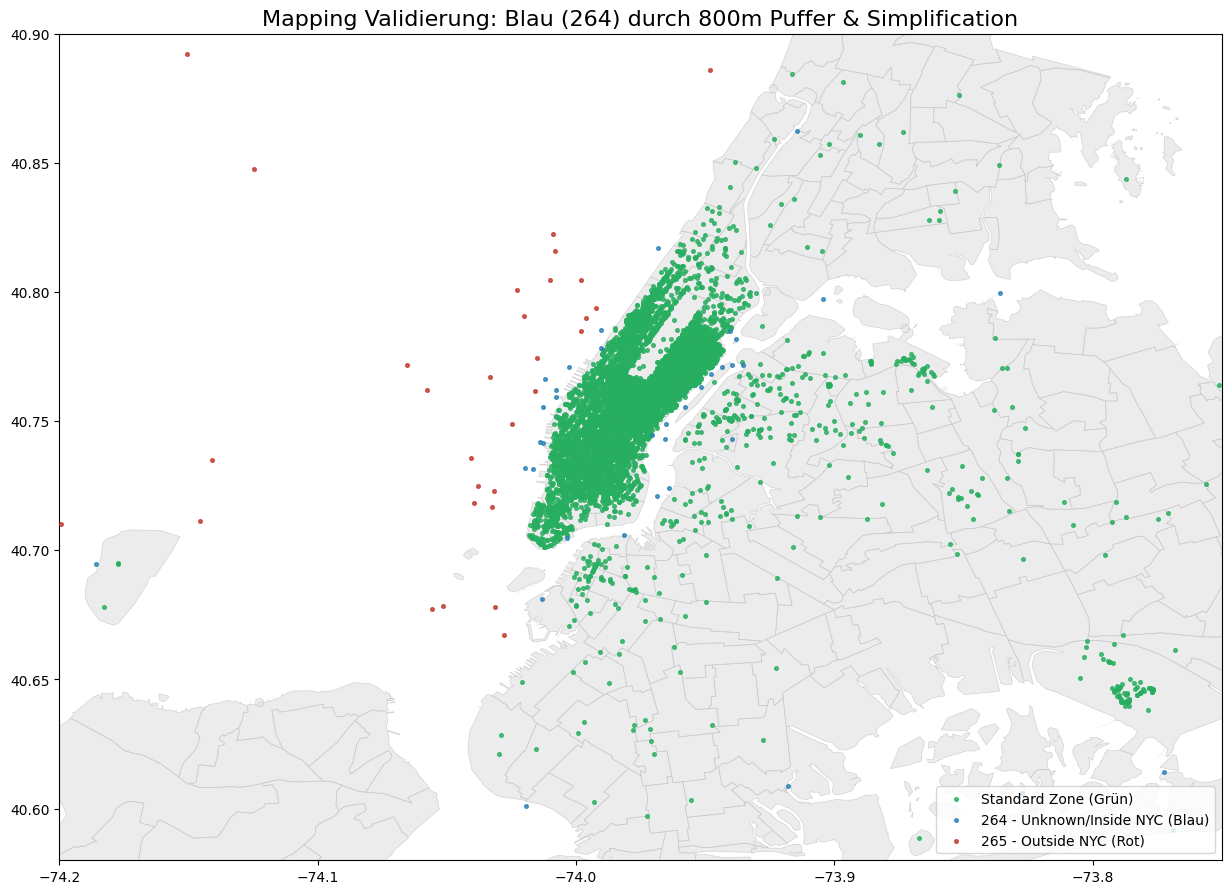

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

# 1. Hintergrund-Karte (Zonen) - Wir vereinfachen sie beim Laden für den Plot
zones_query = f"SELECT ST_SIMPLIFY(zone_geom, 20) as zone_geom FROM `{PROJECT_ID}.{SOURCE_DATASET}.taxi_zones_geo`"
zones_df = client.query(zones_query, location="EU").to_dataframe()
zones_df['geometry'] = zones_df['zone_geom'].apply(wkt.loads)
gdf_zones = gpd.GeoDataFrame(zones_df, geometry='geometry')

# 2. SQL mit ST_SIMPLIFY vor dem ST_BUFFER
query_optimized = f"""
WITH 
  nyc_boundary_buffer AS (
    -- TRICK: Wir vereinfachen die Form um 40 Meter (ST_SIMPLIFY), 
    -- BEVOR wir den 800m Puffer ziehen. Das verhindert den Absturz.
    SELECT ST_BUFFER(ST_SIMPLIFY(ST_UNION_AGG(zone_geom), 40), 800) as city_limit 
    FROM `{PROJECT_ID}.{SOURCE_DATASET}.taxi_zones_geo`
  ),
  sample_2010 AS (
    SELECT 
        dropoff_longitude, dropoff_latitude,
        SAFE.ST_GEOGPOINT(dropoff_longitude, dropoff_latitude) as dropoff_point
    FROM `{PROJECT_ID}.{SOURCE_DATASET}.yellow_schema_5`
    WHERE dropoff_longitude != 0 
      AND dropoff_latitude BETWEEN 40.5 AND 40.95 
      AND dropoff_longitude BETWEEN -74.25 AND -73.7
    LIMIT 10000 -- Etwas kleinere Stichprobe für schnelleren Plot
  ),
  mapping AS (
    SELECT s.*, z.location_id
    FROM sample_2010 s
    LEFT JOIN `{PROJECT_ID}.{SOURCE_DATASET}.taxi_zones_geo` z
      ON ST_WITHIN(s.dropoff_point, z.zone_geom)
  )
SELECT 
    dropoff_longitude, dropoff_latitude,
    CASE 
        WHEN location_id IS NOT NULL THEN 'Standard Zone (Grün)'
        WHEN ST_WITHIN(dropoff_point, (SELECT city_limit FROM nyc_boundary_buffer)) THEN '264 - Unknown/Inside NYC (Blau)'
        ELSE '265 - Outside NYC (Rot)'
    END as category
FROM mapping
"""

print("Führe Query aus (kann 10-20 Sek. dauern)...")
df_points = client.query(query_optimized, location="EU").to_dataframe()

# 3. Visualisierung
fig, ax = plt.subplots(figsize=(15, 12))

# Grauer Hintergrund
gdf_zones.plot(ax=ax, color='#e0e0e0', edgecolor='#bcbcbc', linewidth=0.5, alpha=0.6, zorder=1)

# Punkte plotten
colors = {
    'Standard Zone (Grün)': '#27ae60', 
    '264 - Unknown/Inside NYC (Blau)': '#2980b9', 
    '265 - Outside NYC (Rot)': '#c0392b'
}

for cat, color in colors.items():
    sub = df_points[df_points['category'] == cat]
    if not sub.empty:
        ax.scatter(sub['dropoff_longitude'], sub['dropoff_latitude'], 
                   c=color, label=cat, s=7, alpha=0.8, zorder=3)

ax.set_title("Mapping Validierung: Blau (264) durch 800m Puffer & Simplification", fontsize=16)
ax.set_xlim(-74.20, -73.75)
ax.set_ylim(40.58, 40.90)
plt.legend(loc='lower right')
plt.show()